#Installing Dependencies

In [ ]:
!pip install pycaret

#Feature Correlation Heatmap

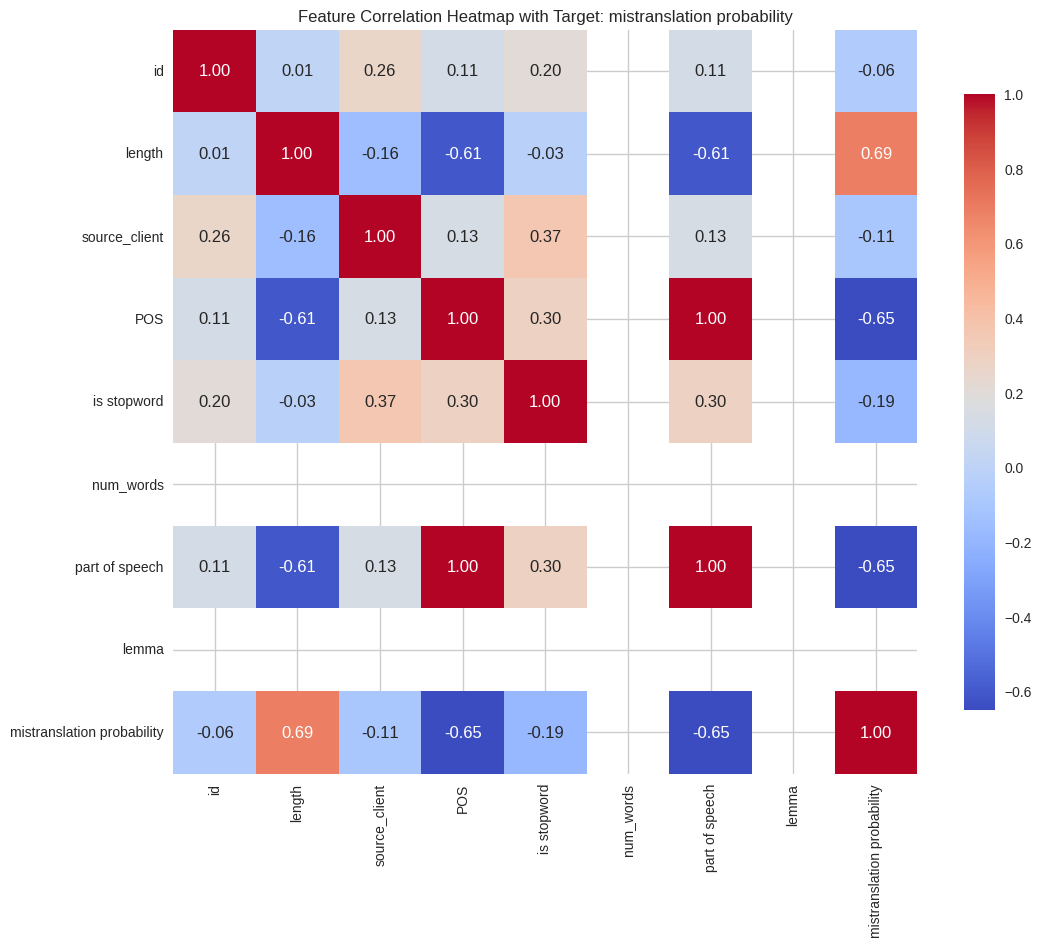

In [ ]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

def preprocess_data_for_heatmap(df, target_column):
    # Remove columns related to 'date_added_to_system'
    df = df.loc[:, ~df.columns.str.contains('date_added_to_system')]

    # Encode categorical columns
    df = encode_categorical_columns(df)

    # Fill missing values
    df.fillna(0, inplace=True)
    return df

def plot_feature_correlation_heatmap(df, target_column):
    # Calculate the correlation matrix
    corr_matrix = df.corr()

    # Plot the heatmap
    plt.figure(figsize=(12, 10))
    sns.heatmap(corr_matrix, annot=True, fmt='.2f', cmap='coolwarm', square=True, cbar_kws={"shrink": .8})
    plt.title(f'Feature Correlation Heatmap with Target: {target_column}')
    plt.show()

def process_and_plot_heatmap():
    df = pd.read_csv('/content/raw_data.csv')
    target_column = 'mistranslation probability'

    # Preprocess data
    df_processed = preprocess_data_for_heatmap(df, target_column)

    # Plot feature correlation heatmap
    plot_feature_correlation_heatmap(df_processed, target_column)

    # The rest of your data handling...
    X, y = preprocess_data(df_processed, target_column)
    X_augmented, y_augmented = augment_data(X, y)

    augmented_data = pd.DataFrame(X_augmented, columns=X.columns)
    augmented_data[target_column] = y_augmented

    augmented_data.to_csv('/content/augmented_data.csv', index=False)

    return augmented_data

augmented_data = process_and_plot_heatmap()


#Pycaret for feature engineering

,Description,Value
0,Session id,123
1,Target,mistranslation probability
2,Target type,Regression
3,Original data shape,"(46, 68)"
4,Transformed data shape,"(46, 82)"
5,Transformed train set shape,"(32, 82)"
6,Transformed test set shape,"(14, 82)"
7,Numeric features,4
8,Categorical features,3
9,Rows with missing values,100.0%


,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE,TT (Sec)
rf,Random Forest Regressor,0.1012,0.0185,0.1170,0.5953,0.0817,0.5265,0.4250
et,Extra Trees Regressor,0.0889,0.0132,0.1025,0.5435,0.0693,0.3252,0.2100
ada,AdaBoost Regressor,0.0979,0.0239,0.1200,0.5309,0.0833,0.6424,0.1740
omp,Orthogonal Matching Pursuit,0.0995,0.0158,0.1188,0.4125,0.0752,0.2629,0.1100
xgboost,Extreme Gradient Boosting,0.1155,0.0320,0.1431,0.3899,0.1011,0.6630,0.1870
gbr,Gradient Boosting Regressor,0.1224,0.0302,0.1445,0.3622,0.0996,0.6638,0.1580
dt,Decision Tree Regressor,0.1170,0.0348,0.1430,0.2913,0.0998,0.6899,0.1870
ridge,Ridge Regression,0.1248,0.0240,0.1473,0.1049,0.1007,0.6720,0.1710
huber,Huber Regressor,0.1331,0.0271,0.1579,-0.0041,0.1069,0.6905,0.1450
lr,Linear Regression,0.1355,0.0278,0.1604,-0.0123,0.1084,0.6742,0.2590


Processing:   0%|          | 0/81 [00:00<?, ?it/s]

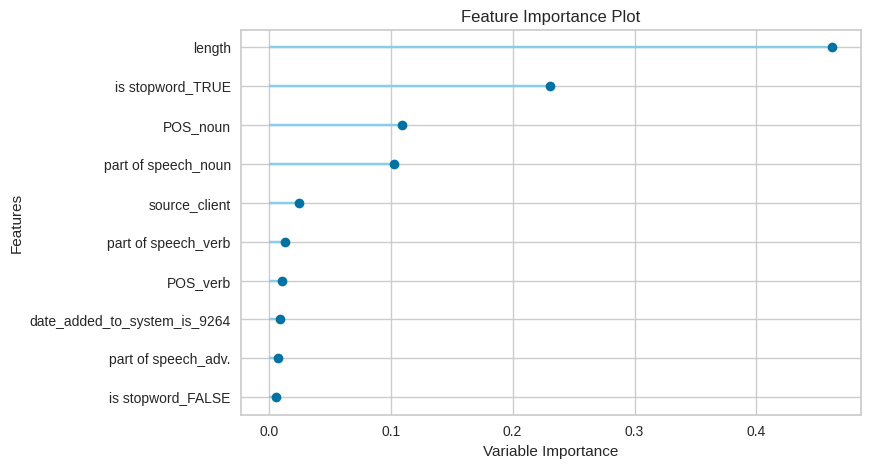

Top 10 Features: ['length', 'source_client', 'POS', 'is stopword', 'num_words', 'date_added_to_system_is_7356', 'date_added_to_system_is_6334', 'date_added_to_system_is_5615', 'part of speech', 'date_added_to_system_is_2720']


In [ ]:
import pandas as pd
from pycaret.regression import setup, compare_models, get_config, plot_model

# Load the data
df = pd.read_csv('/content/raw_data.csv')

# Drop unnecessary columns
df = df.drop(columns=['id'])  # Add other columns to drop as necessary

# Drop rows with missing target values
df = df.dropna(subset=['mistranslation probability'])

# Initialize the PyCaret environment with the data
regression_setup = setup(data=df, target='mistranslation probability', session_id=123, normalize=True)

# Compare models to find the best one
best_model = compare_models()

# Plot feature importance for the best model (Optional: If you want to visualize)
plot_model(best_model, plot='feature')

# Extract the most important features
feature_importance = get_config('X_train').columns
top_features = feature_importance[:10]  # Select the top 10 features

# Return the top 10 features
top_features_list = list(top_features)
print("Top 10 Features:", top_features_list)


#Model training and inference

Fitting 3 folds for each of 10 candidates, totalling 30 fits


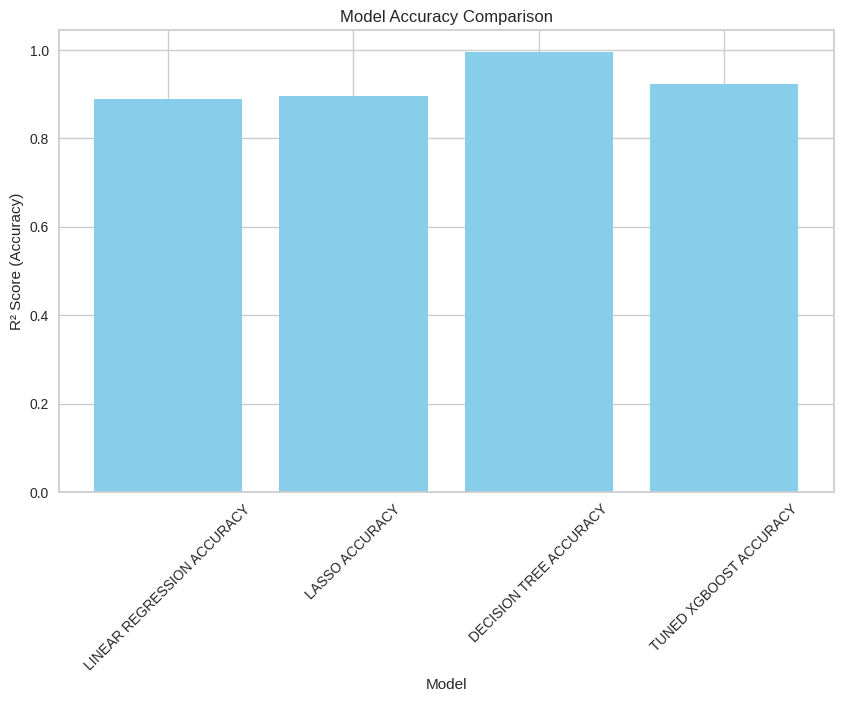

DECISION TREE ACCURACY
0.9949501531243892


In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression, Lasso
from sklearn.metrics import r2_score
from sklearn.model_selection import train_test_split, RandomizedSearchCV
from sklearn.tree import DecisionTreeRegressor
from sklearn.preprocessing import StandardScaler, LabelEncoder
import xgboost as xgb

# Assuming these are your top features from the previous step
top_features = ['length', 'source_client', 'POS', 'is stopword', 'num_words',
                'date_added_to_system_is_7356', 'date_added_to_system_is_6334',
                'date_added_to_system_is_5615', 'part of speech',
                'date_added_to_system_is_2720']

def encode_categorical_columns(df):
    for col in df.columns:
        if df[col].dtype == 'object' and df[col].str.isalpha().any():
            encoder = LabelEncoder()
            df[col] = encoder.fit_transform(df[col])
    return df

def augment_data(X, y):
    noise = np.random.normal(0, 0.1, X.shape)
    X_noisy = X + noise
    X_augmented = np.vstack([X, X_noisy])
    y_augmented = np.hstack([y, y])
    return X_augmented, y_augmented

def preprocess_data(df, target_column, top_features):
    # Keep only the top features and the target column
    df = df[top_features + [target_column]]
    df = encode_categorical_columns(df)
    df.fillna(0, inplace=True)
    X = df.drop(target_column, axis=1)
    y = df[target_column]
    return X, y

def train_and_evaluate_models(X_train, y_train, X_test, y_test):
    results = {}

    regressor = LinearRegression()
    regressor.fit(X_train, y_train)
    y_pred = regressor.predict(X_test)
    results['LINEAR REGRESSION ACCURACY'] = r2_score(y_test, y_pred)

    regressor = Lasso(0.001)
    regressor.fit(X_train, y_train)
    y_pred = regressor.predict(X_test)
    results['LASSO ACCURACY'] = r2_score(y_test, y_pred)

    regressor = DecisionTreeRegressor(random_state=0)
    regressor.fit(X_train, y_train)
    results['DECISION TREE ACCURACY'] = regressor.score(X_test, y_test)

    param_dist = {
        'n_estimators': [100, 200],
        'learning_rate': [0.01, 0.1, 0.2],
        'max_depth': [3, 5, 7],
        'min_child_weight': [1, 5, 10],
        'subsample': [0.8, 1.0],
        'colsample_bytree': [0.8, 1.0]
    }
    xg_regressor = xgb.XGBRegressor(objective='reg:squarederror', eval_metric='rmsle', random_state=42)
    random_search = RandomizedSearchCV(estimator=xg_regressor, param_distributions=param_dist, n_iter=10, cv=3, scoring='r2', verbose=1, random_state=42, n_jobs=-1)
    random_search.fit(X_train, y_train)

    best_model = random_search.best_estimator_
    y_pred = best_model.predict(X_test)
    results['TUNED XGBOOST ACCURACY'] = r2_score(y_test, y_pred)

    return results

def plot_accuracy_bar(results):
    # Plotting the bar plot of accuracy for all models
    plt.figure(figsize=(10, 6))
    plt.bar(results.keys(), results.values(), color='skyblue')
    plt.xlabel('Model')
    plt.ylabel('R² Score (Accuracy)')
    plt.title('Model Accuracy Comparison')
    plt.xticks(rotation=45)
    plt.show()

def get_predictions():
    df = pd.read_csv('/content/raw_data.csv')
    target_column = 'mistranslation probability'

    X, y = preprocess_data(df, target_column, top_features)
    X_augmented, y_augmented = augment_data(X, y)

    X_train, X_test, y_train, y_test = train_test_split(X_augmented, y_augmented, test_size=0.05, random_state=42)

    scaler = StandardScaler()
    X_train = scaler.fit_transform(X_train)
    X_test = scaler.transform(X_test)

    results = train_and_evaluate_models(X_train, y_train, X_test, y_test)

    # Plot the accuracy of the models
    plot_accuracy_bar(results)

    augmented_data = pd.DataFrame(X_augmented, columns=X.columns)
    augmented_data[target_column] = y_augmented

    augmented_data.to_csv('/content/augmented_data.csv', index=False)

    return results, augmented_data

results, augmented_data = get_predictions()
result = max(results.values())
algo = list(results.keys())[list(results.values()).index(result)]
print(algo)
print(result)
